In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch

c:\Users\ankit\anaconda3\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import pandas as pd
import os

X = []  # Initialize an empty list to store concatenated values
y = []  # Initialize an empty list to store labels

# Iterate through transcript IDs from 300 to 493
for transcript_id in range(300, 494):
    filename = f'./transcript/{transcript_id}_TRANSCRIPT.csv'
    label_filename = "./CSV/final_data.csv"  # File containing labels
    
    # Check if the file exists before attempting to read it
    if os.path.exists(filename) and os.path.exists(label_filename):
        # Read the CSV file
        data = pd.read_csv(filename, sep='\t')
        
        # Filter rows where 'speaker' is "Participant" and select 'value' column
        participant_values = data[data['speaker'] == "Participant"]["value"]
        
        # Convert NaN values to empty strings
        participant_values = participant_values.fillna('')
        
        # Join participant values without a separator
        joined_values = ' '.join(participant_values.astype(str).tolist())
        
        # Append joined values to list X
        X.append(joined_values)
        
        # Read the label CSV file
        label_data = pd.read_csv(label_filename)
        
        # Find the corresponding row for the transcript ID
        label_row = label_data[label_data['Participant_ID'] == transcript_id]
        
        # Extract the label from the row
        if not label_row.empty:
            label = label_row.iloc[0]['PHQ8_Binary']
            y.append(label)
       
   

# Print the concatenated values and labels



In [3]:
# Number of rows in X
num_rows_X = len(X)
print("Number of rows in X:", num_rows_X)


Number of rows in X: 170


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Fine-tune RoBERTa
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [6]:
model = model.to('cuda')

In [7]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [12]:
from transformers import TrainingArguments
from transformers import Trainer

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    # # Confusion matrix
    # cm = confusion_matrix(labels, preds)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    # plt.xlabel('Predicted labels')
    # plt.ylabel('True labels')
    # plt.title('Confusion Matrix')
    # plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [12]:
import torch
from transformers import Trainer, TrainingArguments

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

training_args = TrainingArguments(
    output_dir='./output',  # Specify the directory to save the trained model and logs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()

c:\Users\ankit\anaconda3\envs\env\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  2%|▏         | 17/850 [01:18<1:07:49,  4.89s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                  
  2%|▏         | 17/850 [01:26<1:07:49,  4.89s/it]

{'eval_loss': 0.6031811833381653, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 7.6378, 'eval_samples_per_second': 4.452, 'eval_steps_per_second': 0.655, 'epoch': 1.0}


  4%|▍         | 34/850 [02:51<1:07:18,  4.95s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                  
  4%|▍         | 34/850 [02:59<1:07:18,  4.95s/it]

{'eval_loss': 0.5774057507514954, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.0742, 'eval_samples_per_second': 4.211, 'eval_steps_per_second': 0.619, 'epoch': 2.0}


  6%|▌         | 51/850 [04:27<1:10:59,  5.33s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                  
  6%|▌         | 51/850 [04:35<1:10:59,  5.33s/it]

{'eval_loss': 0.580477774143219, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 7.6693, 'eval_samples_per_second': 4.433, 'eval_steps_per_second': 0.652, 'epoch': 3.0}


  8%|▊         | 68/850 [06:04<1:08:38,  5.27s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                  
  8%|▊         | 68/850 [06:12<1:08:38,  5.27s/it]

{'eval_loss': 0.5788016319274902, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.1374, 'eval_samples_per_second': 4.178, 'eval_steps_per_second': 0.614, 'epoch': 4.0}


 10%|█         | 85/850 [07:43<1:09:19,  5.44s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                  
 10%|█         | 85/850 [07:51<1:09:19,  5.44s/it]

{'eval_loss': 0.5498425364494324, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.2724, 'eval_samples_per_second': 4.11, 'eval_steps_per_second': 0.604, 'epoch': 5.0}


 12%|█▏        | 100/850 [09:12<1:06:43,  5.34s/it]

{'loss': 0.7959, 'grad_norm': 5.996889591217041, 'learning_rate': 4.411764705882353e-05, 'epoch': 5.88}


                                                   
 12%|█▏        | 102/850 [09:30<1:06:32,  5.34s/it]

{'eval_loss': 0.5419513583183289, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.6853408029878619, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.693156108597285, 'eval_runtime': 8.194, 'eval_samples_per_second': 4.149, 'eval_steps_per_second': 0.61, 'epoch': 6.0}


                                                   
 14%|█▍        | 119/850 [11:07<1:02:28,  5.13s/it]

{'eval_loss': 0.7087644934654236, 'eval_accuracy': 0.6764705882352942, 'eval_precision': 0.7118983957219251, 'eval_recall': 0.6764705882352942, 'eval_f1': 0.6892544251743251, 'eval_runtime': 8.0009, 'eval_samples_per_second': 4.25, 'eval_steps_per_second': 0.625, 'epoch': 7.0}


                                                   
 16%|█▌        | 136/850 [12:44<1:03:07,  5.31s/it]

{'eval_loss': 0.6710785031318665, 'eval_accuracy': 0.35294117647058826, 'eval_precision': 0.6612576064908722, 'eval_recall': 0.35294117647058826, 'eval_f1': 0.3075335397316822, 'eval_runtime': 8.1038, 'eval_samples_per_second': 4.196, 'eval_steps_per_second': 0.617, 'epoch': 8.0}


 18%|█▊        | 153/850 [14:13<1:01:29,  5.29s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
 18%|█▊        | 153/850 [14:21<1:01:29,  5.29s/it]

{'eval_loss': 0.656146764755249, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.0969, 'eval_samples_per_second': 4.199, 'eval_steps_per_second': 0.618, 'epoch': 9.0}


 20%|██        | 170/850 [15:51<1:00:15,  5.32s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                   
 20%|██        | 170/850 [15:59<1:00:15,  5.32s/it]

{'eval_loss': 0.579375147819519, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 7.9519, 'eval_samples_per_second': 4.276, 'eval_steps_per_second': 0.629, 'epoch': 10.0}


 22%|██▏       | 187/850 [17:28<58:16,  5.27s/it]  c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 22%|██▏       | 187/850 [17:36<58:16,  5.27s/it]

{'eval_loss': 0.5785248279571533, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.1442, 'eval_samples_per_second': 4.175, 'eval_steps_per_second': 0.614, 'epoch': 11.0}


 24%|██▎       | 200/850 [18:45<58:40,  5.42s/it]  

{'loss': 0.6071, 'grad_norm': 1.6169605255126953, 'learning_rate': 3.8235294117647055e-05, 'epoch': 11.76}


 24%|██▍       | 204/850 [19:05<56:03,  5.21s/it]  c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 24%|██▍       | 204/850 [19:13<56:03,  5.21s/it]

{'eval_loss': 0.5786821246147156, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.0151, 'eval_samples_per_second': 4.242, 'eval_steps_per_second': 0.624, 'epoch': 12.0}


 26%|██▌       | 221/850 [20:43<55:57,  5.34s/it]  c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 26%|██▌       | 221/850 [20:51<55:57,  5.34s/it]

{'eval_loss': 0.5778275728225708, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 7.9755, 'eval_samples_per_second': 4.263, 'eval_steps_per_second': 0.627, 'epoch': 13.0}


 28%|██▊       | 238/850 [22:20<53:19,  5.23s/it]  c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 28%|██▊       | 238/850 [22:28<53:19,  5.23s/it]

{'eval_loss': 0.5812520384788513, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.1095, 'eval_samples_per_second': 4.193, 'eval_steps_per_second': 0.617, 'epoch': 14.0}


 30%|███       | 255/850 [23:58<52:03,  5.25s/it]  c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 30%|███       | 255/850 [24:06<52:03,  5.25s/it]

{'eval_loss': 0.5762227177619934, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.1842, 'eval_samples_per_second': 4.154, 'eval_steps_per_second': 0.611, 'epoch': 15.0}


                                                   
 32%|███▏      | 272/850 [25:43<50:54,  5.28s/it]

{'eval_loss': 0.5861477851867676, 'eval_accuracy': 0.6764705882352942, 'eval_precision': 0.7118983957219251, 'eval_recall': 0.6764705882352942, 'eval_f1': 0.6892544251743251, 'eval_runtime': 8.2197, 'eval_samples_per_second': 4.136, 'eval_steps_per_second': 0.608, 'epoch': 16.0}


                                                   
 34%|███▍      | 289/850 [27:21<48:58,  5.24s/it]

{'eval_loss': 0.6485224962234497, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.6337760910815939, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.6481092436974789, 'eval_runtime': 7.9577, 'eval_samples_per_second': 4.273, 'eval_steps_per_second': 0.628, 'epoch': 17.0}


 35%|███▌      | 300/850 [28:19<49:17,  5.38s/it]  

{'loss': 0.607, 'grad_norm': 5.132479667663574, 'learning_rate': 3.235294117647059e-05, 'epoch': 17.65}


 36%|███▌      | 306/850 [28:51<47:52,  5.28s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 36%|███▌      | 306/850 [28:59<47:52,  5.28s/it]

{'eval_loss': 0.5714195370674133, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 8.1391, 'eval_samples_per_second': 4.177, 'eval_steps_per_second': 0.614, 'epoch': 18.0}


                                                   
 38%|███▊      | 323/850 [30:36<47:10,  5.37s/it]

{'eval_loss': 0.546101450920105, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.6960784313725491, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6964212258329905, 'eval_runtime': 7.2825, 'eval_samples_per_second': 4.669, 'eval_steps_per_second': 0.687, 'epoch': 19.0}


                                                   
 40%|████      | 340/850 [32:14<44:30,  5.24s/it]

{'eval_loss': 0.5092693567276001, 'eval_accuracy': 0.7647058823529411, 'eval_precision': 0.7837712159962799, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7715686274509803, 'eval_runtime': 8.1715, 'eval_samples_per_second': 4.161, 'eval_steps_per_second': 0.612, 'epoch': 20.0}


                                                   
 42%|████▏     | 357/850 [33:50<43:27,  5.29s/it]

{'eval_loss': 0.6166386604309082, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.5347593582887701, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.6085192697768763, 'eval_runtime': 7.9819, 'eval_samples_per_second': 4.26, 'eval_steps_per_second': 0.626, 'epoch': 21.0}


                                                   
 44%|████▍     | 374/850 [35:26<41:19,  5.21s/it]

{'eval_loss': 0.6006547212600708, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.767379679144385, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.7457536205971751, 'eval_runtime': 7.942, 'eval_samples_per_second': 4.281, 'eval_steps_per_second': 0.63, 'epoch': 22.0}


                                                   
 46%|████▌     | 391/850 [37:03<38:38,  5.05s/it]

{'eval_loss': 0.5676410794258118, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.7262443438914028, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.7301038062283736, 'eval_runtime': 7.8541, 'eval_samples_per_second': 4.329, 'eval_steps_per_second': 0.637, 'epoch': 23.0}


 47%|████▋     | 400/850 [37:49<39:23,  5.25s/it]

{'loss': 0.475, 'grad_norm': 10.450671195983887, 'learning_rate': 2.647058823529412e-05, 'epoch': 23.53}


                                                 
 48%|████▊     | 408/850 [38:38<38:17,  5.20s/it]

{'eval_loss': 0.6206323504447937, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.7814241486068111, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.7225935828877005, 'eval_runtime': 7.973, 'eval_samples_per_second': 4.264, 'eval_steps_per_second': 0.627, 'epoch': 24.0}


 50%|█████     | 425/850 [40:07<37:48,  5.34s/it]c:\Users\ankit\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 50%|█████     | 425/850 [40:15<37:48,  5.34s/it]

{'eval_loss': 1.0705583095550537, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.5406574394463668, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6231306081754736, 'eval_runtime': 7.7497, 'eval_samples_per_second': 4.387, 'eval_steps_per_second': 0.645, 'epoch': 25.0}


                                                 
 52%|█████▏    | 442/850 [41:51<34:59,  5.15s/it]

{'eval_loss': 0.9952172636985779, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.5347593582887701, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.6085192697768763, 'eval_runtime': 7.9942, 'eval_samples_per_second': 4.253, 'eval_steps_per_second': 0.625, 'epoch': 26.0}


                                                 
 54%|█████▍    | 459/850 [43:37<35:53,  5.51s/it]

{'eval_loss': 1.2288929224014282, 'eval_accuracy': 0.7058823529411765, 'eval_precision': 0.5347593582887701, 'eval_recall': 0.7058823529411765, 'eval_f1': 0.6085192697768763, 'eval_runtime': 7.8798, 'eval_samples_per_second': 4.315, 'eval_steps_per_second': 0.635, 'epoch': 27.0}


                                                 
 56%|█████▌    | 476/850 [45:13<32:36,  5.23s/it]

{'eval_loss': 1.1928136348724365, 'eval_accuracy': 0.7352941176470589, 'eval_precision': 0.6960784313725491, 'eval_recall': 0.7352941176470589, 'eval_f1': 0.6964212258329905, 'eval_runtime': 7.9776, 'eval_samples_per_second': 4.262, 'eval_steps_per_second': 0.627, 'epoch': 28.0}


                                                 
 58%|█████▊    | 493/850 [46:50<31:00,  5.21s/it]

{'eval_loss': 0.8523944616317749, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8154372860255215, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.815893665158371, 'eval_runtime': 7.9998, 'eval_samples_per_second': 4.25, 'eval_steps_per_second': 0.625, 'epoch': 29.0}


 59%|█████▉    | 500/850 [47:27<32:05,  5.50s/it]

{'loss': 0.2751, 'grad_norm': 0.26262620091438293, 'learning_rate': 2.058823529411765e-05, 'epoch': 29.41}


                                                 
 60%|██████    | 510/850 [48:31<31:44,  5.60s/it]

{'eval_loss': 0.9261951446533203, 'eval_accuracy': 0.7647058823529411, 'eval_precision': 0.74573055028463, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7184873949579832, 'eval_runtime': 7.1942, 'eval_samples_per_second': 4.726, 'eval_steps_per_second': 0.695, 'epoch': 30.0}


                                                 
 62%|██████▏   | 527/850 [50:09<28:23,  5.27s/it]

{'eval_loss': 0.8253732323646545, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.8391544117647058, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7412515245332583, 'eval_runtime': 7.8485, 'eval_samples_per_second': 4.332, 'eval_steps_per_second': 0.637, 'epoch': 31.0}


                                                 
 64%|██████▍   | 544/850 [51:47<26:47,  5.25s/it]

{'eval_loss': 0.8580695986747742, 'eval_accuracy': 0.7647058823529411, 'eval_precision': 0.74573055028463, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7184873949579832, 'eval_runtime': 7.8892, 'eval_samples_per_second': 4.31, 'eval_steps_per_second': 0.634, 'epoch': 32.0}


                                                 
 66%|██████▌   | 561/850 [53:23<25:45,  5.35s/it]

{'eval_loss': 0.7786317467689514, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.8391544117647058, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7412515245332583, 'eval_runtime': 7.4071, 'eval_samples_per_second': 4.59, 'eval_steps_per_second': 0.675, 'epoch': 33.0}


                                                 
 68%|██████▊   | 578/850 [54:59<23:28,  5.18s/it]

{'eval_loss': 0.918927788734436, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.7867647058823529, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7638831756478816, 'eval_runtime': 7.8795, 'eval_samples_per_second': 4.315, 'eval_steps_per_second': 0.635, 'epoch': 34.0}


                                                 
 70%|███████   | 595/850 [56:35<22:02,  5.19s/it]

{'eval_loss': 1.048978328704834, 'eval_accuracy': 0.7647058823529411, 'eval_precision': 0.7419878296146044, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7398070339246811, 'eval_runtime': 7.9505, 'eval_samples_per_second': 4.276, 'eval_steps_per_second': 0.629, 'epoch': 35.0}


 71%|███████   | 600/850 [57:01<23:50,  5.72s/it]

{'loss': 0.1963, 'grad_norm': 2.829937696456909, 'learning_rate': 1.4705882352941177e-05, 'epoch': 35.29}


                                                 
 72%|███████▏  | 612/850 [58:11<20:27,  5.16s/it]

{'eval_loss': 1.0339770317077637, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.7804621848739496, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7793562708102107, 'eval_runtime': 7.9294, 'eval_samples_per_second': 4.288, 'eval_steps_per_second': 0.631, 'epoch': 36.0}


                                                 
 74%|███████▍  | 629/850 [59:47<19:14,  5.22s/it]

{'eval_loss': 1.1000410318374634, 'eval_accuracy': 0.7647058823529411, 'eval_precision': 0.7419878296146044, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7398070339246811, 'eval_runtime': 7.7878, 'eval_samples_per_second': 4.366, 'eval_steps_per_second': 0.642, 'epoch': 37.0}


                                                   
 76%|███████▌  | 646/850 [1:01:23<17:43,  5.21s/it]

{'eval_loss': 0.9711341857910156, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.7804621848739496, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7793562708102107, 'eval_runtime': 7.8921, 'eval_samples_per_second': 4.308, 'eval_steps_per_second': 0.634, 'epoch': 38.0}


                                                   
 78%|███████▊  | 663/850 [1:02:59<16:12,  5.20s/it]

{'eval_loss': 1.0000207424163818, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.7804621848739496, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7793562708102107, 'eval_runtime': 7.9714, 'eval_samples_per_second': 4.265, 'eval_steps_per_second': 0.627, 'epoch': 39.0}


                                                   
 80%|████████  | 680/850 [1:04:35<14:32,  5.13s/it]

{'eval_loss': 0.8901753425598145, 'eval_accuracy': 0.7647058823529411, 'eval_precision': 0.74573055028463, 'eval_recall': 0.7647058823529411, 'eval_f1': 0.7184873949579832, 'eval_runtime': 7.9393, 'eval_samples_per_second': 4.283, 'eval_steps_per_second': 0.63, 'epoch': 40.0}


                                                   
 82%|████████▏ | 697/850 [1:06:11<13:02,  5.12s/it]

{'eval_loss': 0.8622046709060669, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8154372860255215, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.815893665158371, 'eval_runtime': 7.9128, 'eval_samples_per_second': 4.297, 'eval_steps_per_second': 0.632, 'epoch': 41.0}


 82%|████████▏ | 700/850 [1:06:27<15:32,  6.22s/it]

{'loss': 0.1921, 'grad_norm': 6.1852707862854, 'learning_rate': 8.823529411764707e-06, 'epoch': 41.18}


                                                   
 84%|████████▍ | 714/850 [1:07:48<11:31,  5.09s/it]

{'eval_loss': 0.9025042057037354, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8154372860255215, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.815893665158371, 'eval_runtime': 7.9312, 'eval_samples_per_second': 4.287, 'eval_steps_per_second': 0.63, 'epoch': 42.0}


                                                   
 86%|████████▌ | 731/850 [1:09:24<10:11,  5.14s/it]

{'eval_loss': 0.6813297867774963, 'eval_accuracy': 0.8529411764705882, 'eval_precision': 0.8508403361344538, 'eval_recall': 0.8529411764705882, 'eval_f1': 0.8423973362930076, 'eval_runtime': 7.9147, 'eval_samples_per_second': 4.296, 'eval_steps_per_second': 0.632, 'epoch': 43.0}


                                                   
 88%|████████▊ | 748/850 [1:11:00<09:03,  5.33s/it]

{'eval_loss': 0.9022487998008728, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8154372860255215, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.815893665158371, 'eval_runtime': 7.1904, 'eval_samples_per_second': 4.729, 'eval_steps_per_second': 0.695, 'epoch': 44.0}


                                                   
 90%|█████████ | 765/850 [1:12:36<07:24,  5.23s/it]

{'eval_loss': 0.8554081916809082, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.7867647058823529, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7638831756478816, 'eval_runtime': 7.8908, 'eval_samples_per_second': 4.309, 'eval_steps_per_second': 0.634, 'epoch': 45.0}


                                                   
 92%|█████████▏| 782/850 [1:14:11<05:41,  5.03s/it]

{'eval_loss': 0.868661105632782, 'eval_accuracy': 0.7941176470588235, 'eval_precision': 0.7867647058823529, 'eval_recall': 0.7941176470588235, 'eval_f1': 0.7638831756478816, 'eval_runtime': 7.7792, 'eval_samples_per_second': 4.371, 'eval_steps_per_second': 0.643, 'epoch': 46.0}


                                                   
 94%|█████████▍| 799/850 [1:15:46<04:21,  5.13s/it]

{'eval_loss': 0.9419775605201721, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8154372860255215, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.815893665158371, 'eval_runtime': 7.682, 'eval_samples_per_second': 4.426, 'eval_steps_per_second': 0.651, 'epoch': 47.0}


 94%|█████████▍| 800/850 [1:15:51<06:04,  7.30s/it]

{'loss': 0.1575, 'grad_norm': 0.18080858886241913, 'learning_rate': 2.9411764705882355e-06, 'epoch': 47.06}


                                                   
 96%|█████████▌| 816/850 [1:18:38<07:19, 12.94s/it]

{'eval_loss': 0.9013295769691467, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8154372860255215, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.815893665158371, 'eval_runtime': 13.9755, 'eval_samples_per_second': 2.433, 'eval_steps_per_second': 0.358, 'epoch': 48.0}


                                                   
 98%|█████████▊| 833/850 [1:21:00<01:39,  5.86s/it]

{'eval_loss': 0.8791314363479614, 'eval_accuracy': 0.8235294117647058, 'eval_precision': 0.8235294117647058, 'eval_recall': 0.8235294117647058, 'eval_f1': 0.8235294117647058, 'eval_runtime': 9.3477, 'eval_samples_per_second': 3.637, 'eval_steps_per_second': 0.535, 'epoch': 49.0}


                                                   
100%|██████████| 850/850 [1:23:18<00:00,  5.88s/it]

{'eval_loss': 0.8508814573287964, 'eval_accuracy': 0.8529411764705882, 'eval_precision': 0.8489819004524887, 'eval_recall': 0.8529411764705882, 'eval_f1': 0.8500576701268744, 'eval_runtime': 26.7633, 'eval_samples_per_second': 1.27, 'eval_steps_per_second': 0.187, 'epoch': 50.0}
{'train_runtime': 4998.5775, 'train_samples_per_second': 1.36, 'train_steps_per_second': 0.17, 'train_loss': 0.3929042185054106, 'epoch': 50.0}


In [15]:
trainer.save_model('/models')

In [40]:
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification

# Save the trained model
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model.save_pretrained(model_dir)

# Save the tokenizer
tokenizer.save_pretrained(model_dir)

# Save the config
config = RobertaConfig.from_pretrained(model_dir)
config.save_pretrained(model_dir)

In [18]:
eval_results = trainer.evaluate(eval_dataset=test_dataset)


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


In [19]:
# Print evaluation results
print(eval_results)

{'eval_loss': 0.8508814573287964, 'eval_accuracy': 0.8529411764705882, 'eval_precision': 0.8489819004524887, 'eval_recall': 0.8529411764705882, 'eval_f1': 0.8500576701268744, 'eval_runtime': 15.1498, 'eval_samples_per_second': 2.244, 'eval_steps_per_second': 0.33, 'epoch': 50.0}


In [16]:
predictions = trainer.predict(test_dataset)

100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


In [17]:
predicted_labels = np.argmax(predictions.predictions, axis=1)

In [18]:
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

In [19]:
class_report = classification_report(y_test, predicted_labels, target_names=['undepressed', 'depressed'])

In [20]:

print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

 undepressed       0.88      0.92      0.90        25
   depressed       0.75      0.67      0.71         9

    accuracy                           0.85        34
   macro avg       0.82      0.79      0.80        34
weighted avg       0.85      0.85      0.85        34



In [38]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


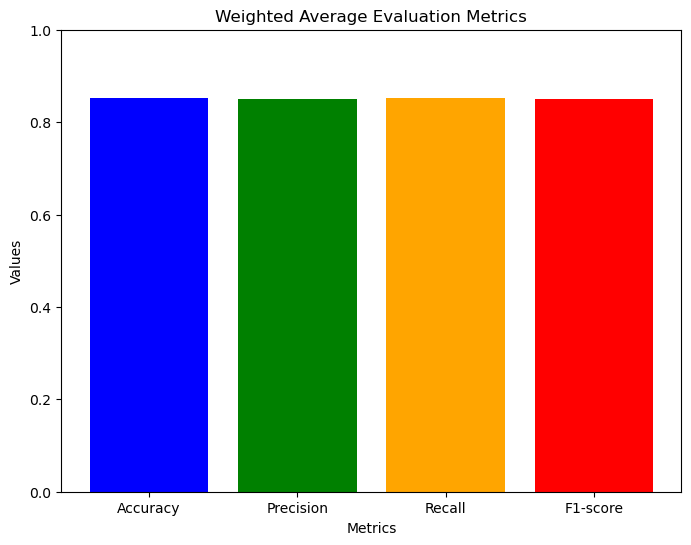

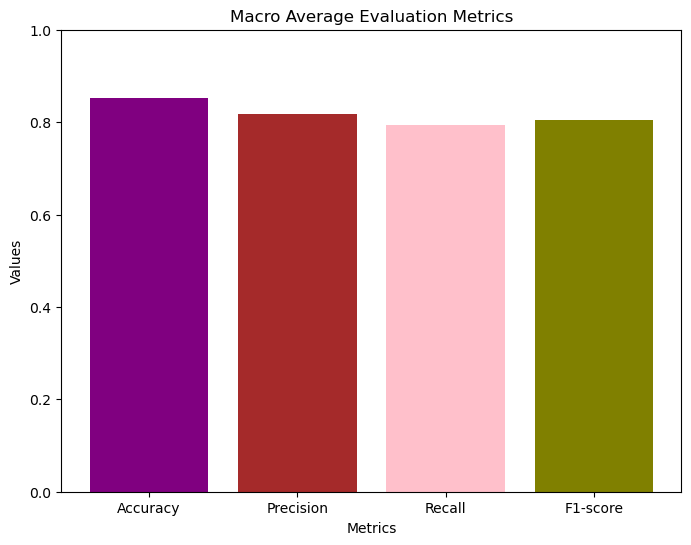

In [25]:
from sklearn.metrics import classification_report

eval_results = trainer.evaluate()
class_report = classification_report(y_test, predicted_labels, target_names=['undepressed', 'depressed'], output_dict=True)

accuracy = class_report['accuracy']
precision_weighted = class_report['weighted avg']['precision']
recall_weighted = class_report['weighted avg']['recall']
f1_weighted = class_report['weighted avg']['f1-score']

precision_macro = class_report['macro avg']['precision']
recall_macro = class_report['macro avg']['recall']
f1_macro = class_report['macro avg']['f1-score']

# Plot weighted average metrics
plt.figure(figsize=(8, 6))
metrics_weighted = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values_weighted = [accuracy, precision_weighted, recall_weighted, f1_weighted]
plt.bar(metrics_weighted, values_weighted, color=['blue', 'green', 'orange', 'red'])
plt.title('Weighted Average Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)
plt.show()

# Plot macro average metrics
plt.figure(figsize=(8, 6))
metrics_macro = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values_macro = [accuracy, precision_macro, recall_macro, f1_macro]
plt.bar(metrics_macro, values_macro, color=['purple', 'brown', 'pink', 'olive'])
plt.title('Macro Average Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)
plt.show()

In [27]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

In [28]:
conf_matrix

array([[23,  2],
       [ 3,  6]], dtype=int64)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['undepressed', 'depressed'], yticklabels=['undepressed', 'depressed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [35]:
conf_matrix

array([[23,  2],
       [ 3,  6]], dtype=int64)

Evaluate from saved model

In [5]:
from transformers import RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification

model_dir = 'models'
config = RobertaConfig.from_pretrained(model_dir)
model = RobertaForSequenceClassification.from_pretrained(model_dir, config=config)
tokenizer = RobertaTokenizer.from_pretrained(model_dir)

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

In [13]:
training_args = TrainingArguments(
    output_dir='./output',  # Specify the directory to save the trained model and logs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy='epoch',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

c:\Users\ankit\anaconda3\envs\env\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [14]:
eval_results = trainer.evaluate(test_dataset)

100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


In [15]:
# Print evaluation results
print(eval_results)

{'eval_loss': 0.8508814573287964, 'eval_accuracy': 0.8529411764705882, 'eval_precision': 0.8489819004524887, 'eval_recall': 0.8529411764705882, 'eval_f1': 0.8500576701268744, 'eval_runtime': 1.1147, 'eval_samples_per_second': 30.503, 'eval_steps_per_second': 4.486}
